In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from lmfit.models import GaussianModel

In [2]:
from astropy.table import Table,vstack,unique
from astropy.io import fits
import glob

# To Dos
- ready to properly do statistic!
- make sure same answer given by lcurve

# Define Functions

In [3]:
def sf(file,dpi=200):
    plt.savefig(file+'.png',dpi=dpi,bbox_inches=False)

In [87]:
def detrend(x2,y2,plot=False,retx=False,err=True,cerr=0,drop=True):
    '''Detrend LC by redefining counts as ratio of counts to linear best fit to data.
    If it's easier, can change to use hist as argument rather than x and y'''
    #find linear best fit to data
    #excluse points with zero count rate (btwn obsids)
    #if drop is True, gets rid of counts of 0
    #not needed if called from lcfr
    if drop:
        indz = np.where(y2!=0)[0]
        x = x2[indz]
        y = y2[indz]
        cerr2 = cerr[indz]
    else:
        x = x2
        y = y2
        cerr2 = cerr
    mod = np.polyfit(x,y,1)
    #detrended data is ratio of original counts to linear fit
    det = y/(mod[0]*x+mod[1])
    if err: nerr = cerr2/(mod[0]*x+mod[1])
    if plot:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].plot(x,mod[0]*x+mod[1],color='red')
        ax[0].scatter(x,y,color='black')
        ax[1].scatter(x,det,color='black')
        ax[1].set_ylabel('Detrended Counts')
        ax[0].set_ylabel('Counts')
        ax[0].set_xlabel('Days')
    if retx and err: return x,det,nerr
    elif retx: return x,det
    elif err: return det,nerr
    else: return det

In [4]:
def periodogram(time,counts,minp,maxp,sec=True,plot=True):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(time, counts)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/maxp,
                           maximum_frequency=1/minp,
                           samples_per_peak=10)
#     if bayes: power = np.exp(power)
    if sec and plot: plt.plot((1/freq)/(3600*24),power,color='black')
    elif plot: plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    if plot:
        plt.xlabel('Period',fontsize=14)
        plt.ylabel('Power',fontsize=14)
#     if more:
#         return freq, power, 1/best_freq
    if sec: return ('days:',(1/best_freq)/(3600*24))
    else: return 1/best_freq

# Read in Event Files

In [5]:
evts = glob.glob('s*.fits')
evts

['src_13816.fits',
 'src_15496.fits',
 'src_13812.fits',
 'src_15553.fits',
 'src_13813.fits',
 'src_13814.fits',
 'src_13815.fits']

In [6]:
#make list of astropy event tables
#seven elements for seven obsids
tabs = []
for e in evts:
    hdu_list = fits.open(e, memmap=True)
    t = Table(hdu_list[1].data)
    #add row to astropy table for days
    #can adjust to use mjdref later
    t['day'] = t['time']/(3600*24)
    tabs.append(t)
    print(e,t['time'][0])

src_13816.fits 465025372.8442148
src_15496.fits 464434911.77284586
src_13812.fits 463862614.391263
src_15553.fits 466218621.51459354
src_13813.fits 463601910.9877028
src_13814.fits 464514703.4699503
src_13815.fits 464776486.86331296


In [7]:
def sorf(e):
    return e['day'][0]
#sort list of tables by start time in each
tabs.sort(key=sorf)

In [11]:
#only keep ones with eclipses (0,1,3)
tabs = [tabs[0],tabs[1],tabs[3]]

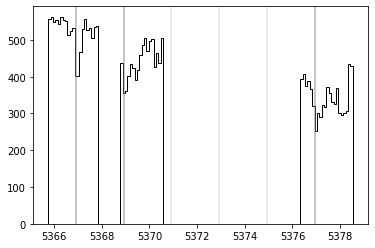

In [21]:
h1 = plt.hist(tabs[0]['day'],bins=np.arange(tabs[0]['day'][0],tabs[0]['day'][-1],0.1),histtype='step',color='black')
h2 = plt.hist(tabs[1]['day'],bins=np.arange(tabs[1]['day'][0],tabs[1]['day'][-1],0.1),histtype='step',color='black')
h3 = plt.hist(tabs[2]['day'],bins=np.arange(tabs[2]['day'][0],tabs[2]['day'][-1],0.1),histtype='step',color='black')
plt.axvline(5366.93,color='grey',alpha=.6)
plt.axvline(5368.93,color='grey',alpha=.6)
plt.axvline(5370.93,color='grey',alpha=.2)
plt.axvline(5372.93,color='grey',alpha=.2)
plt.axvline(5374.93,color='grey',alpha=.2)
plt.axvline(5376.93,color='grey',alpha=.6) #grey lines show three eclipses

In [16]:
#make astropy table of all events (stack obsids)
join = vstack(tabs)

In [17]:
#make sure only unique events kept
join = unique(join,keys='time')

- so we want to fold a lightcurve rather than evts
- lightcurve already has even time binning
- so we essentially want to bin within the counts or det vs. day plot
- we can do this with arrays by reshaping and summing along that axis

# initial goal: phase-fold lightcurve by some period and give S

In [66]:
#define function to make lightcurve hist using table of events
def lc(evt,dbin):
    '''
    evt: table of events, including time in days, or list of tables of events
    dbin: size of bin in days
    TO DO: rather than list, just add obsid and do find allbins without a loop
    non-constant bin width so need to divide by bin width for count rate
    count rate per day so higher than original in each bin
    '''
    #list of event tables (see to-do)
    if isinstance(evt,list):
        allb = []
        for i in range(len(evt)):
            tbins = np.arange(tabs[i]['day'][0],tabs[i]['day'][-1],dbin)
            #add last time in obsid to list of bins
            #addition of small offset so that that last time count is included in bin and not between obsids
            offset = 1e-2*dbin
            tbins = np.concatenate([tbins,[offset+tabs[i]['day'][-1]]])
            allb.append(tbins)
        #make into one array rather than list of seven arrays
        allb = np.concatenate(allb)
        #join tables
        join = vstack(tabs)
        join = unique(join,keys='time')
        h = plt.hist(join['day'],bins=allb,histtype='step',color='black')
        #count err
        cerr = np.sqrt(h[0])
        #immediately divide by bin width to avoid confusion down the line
        bin_wid = h[1][1:]-h[1][:-1] #width is end of bin - beginning of bin
        #calculate count rate using counts and bin width
        cr = h[0]/bin_wid
        #divide error 
        crerr = cerr/bin_wid
        #CR PER DAY SO INCREASES FROM ORIGINAL
        newh = (cr,h[1])
        #for now, outputs original histogram but returns cr
        return newh, crerr
    else:
        h = plt.hist(evt['day'],bins=np.arange(evt['day'][0],evt['day'][-1],dbin),histtype='step',color='black')
        err = np.sqrt(h[0])
    return h,err

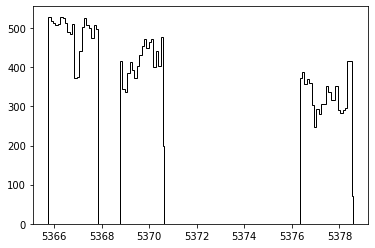

In [56]:
l,crerr = lc(tabs,0.1)

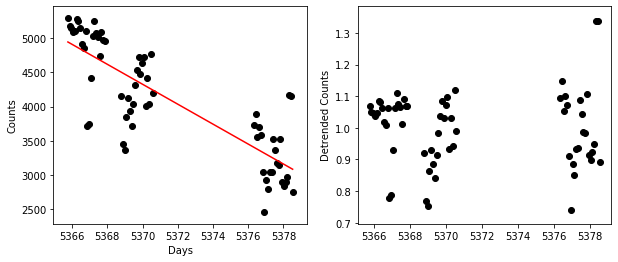

In [61]:
nzx,det,nerr = detrend(l[1][:-1],l[0],plot=True,retx=True,err=True,cerr=crerr)

Text(0.5, 0, 'Phase (1.9969 d)')

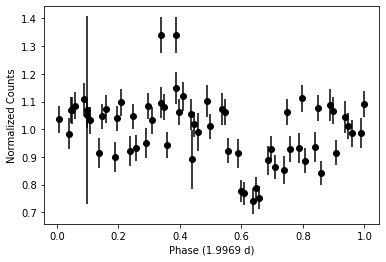

In [62]:
plt.errorbar((nzx%1.9969)/1.9969,det,yerr=nerr,linestyle='none',marker='o',color='black')
plt.ylabel('Normalized Counts')
plt.xlabel('Phase (1.9969 d)')
# sf('detfold') #add average using phase binning

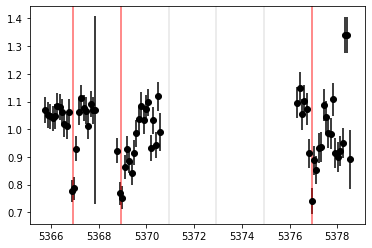

In [65]:
plt.errorbar(nzx,det,yerr=nerr,color='black',linestyle='none',marker='o')
plt.axvline(5366.93,color='red',alpha=.6)
plt.axvline(5368.93,color='red',alpha=.6)
plt.axvline(5370.93,color='grey',alpha=.2)
plt.axvline(5372.93,color='grey',alpha=.2)
plt.axvline(5374.93,color='grey',alpha=.2)
plt.axvline(5376.93,color='red',alpha=.6) #grey lines show three eclipses


In [84]:
#one function creating lightcurve and making DataFrame, including detrended column
def lcfr(evt,dbin,det=True):
    h,err = lc(evt,dbin)
    plt.close()
    fr = pd.DataFrame(columns=['day','counts','count err','det','det err','bin'])
    #can update to get better time estimate (central time rather than bin start time)
    fr['day'] = h[1][:-1]
    fr['counts'] = h[0]
    fr['count err'] = err
    #bin width (exposure time) in bin column
    fr['bin'] = (h[1][1:]-h[1][:-1])
    #find places with zero counts and delete from DataFrame
    btwn = np.where(fr['counts']==0)
    btwn = list(btwn[0])
    fr = fr.drop(index=btwn)
    if det: 
        #already dropped zeros in this case
        detr,deterr = detrend(fr['day'],fr['counts'],err=True,cerr=fr['count err'],drop=False)
        fr['det'] = detr
        fr['det err'] = deterr
    return fr

In [88]:
fr = lcfr(tabs,0.1) #defaults to including detrending now

In [110]:
fr['bin'][20:30]

20    0.100000
21    0.002017
23    0.100000
24    0.100000
25    0.100000
26    0.100000
27    0.100000
28    0.100000
29    0.100000
30    0.100000
Name: bin, dtype: float64

<ErrorbarContainer object of 3 artists>

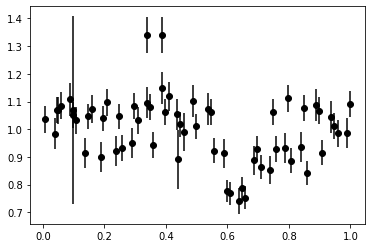

In [89]:
plt.errorbar((fr['day']%1.9969)/1.9969,fr['det'],yerr=fr['det err'],linestyle='none',marker='o',color='black')


In [113]:
np.arange(1/10,1,1/10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [122]:
fr2 = fr
fr2['phase'] = (fr['day']%2)/2

In [137]:
float(fr['phase'][2:3])

0.14650641192281658

In [198]:
np.arange(1/10,1+1/10,1/10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [209]:
def nfold(evt,pd,dbin=0.1,pbins=16,color='red',linestyle='solid'):
    '''
    new fold function: plot original folded points and line using phase-fold
    assumes you want detrended data for now
    '''
    if isinstance(evt,list):
        fr = lcfr(evt,dbin)
    #if ready-made DataFrame from lcfr function passed in
    else:
        fr = evt
    #now phase always goes up to 1
    fr['phase'] = (fr['day']%pd)/pd
    fr = fr.sort_values(by='phase',ascending=True)
#         ph = plt.hist(fr['phase']/pd,bins=pbins,weights=fr['det'],histtype='step',color=color,linestyle=linestyle)
    plt.close()
    #find average count rate in each phase bin
        
    #other method with just loop length of number of phase bins
    #for now just one to do all the necessary filtering
    avgs = [] #list of average count rate in each phase bin
    endb = np.arange(1/pbins,1+1/pbins,1/pbins)
    for p in endb:
        #phase in temporary df is less than phase in endb and more than the previous one
        tempfr = fr[fr['phase']<=p]
        tempfr = tempfr[tempfr['phase']>p-1/pbins]
        avgs.append(np.mean(tempfr['det']))
    plt.figure(figsize=(8,4))
    endb2 = np.concatenate([np.array([0]),endb])
    mid = (endb2[1:]+endb2[:-1])/2
    plt.plot(mid,avgs,color=color,linestyle=linestyle)
    plt.ylabel('Normalized Rate')
    plt.xlabel('Phase ('+str(pd)+'d)')
    plt.errorbar(fr['phase'],fr['det'],yerr=fr['det err'],linestyle='none',marker='o',color='black')

    return fr,avgs

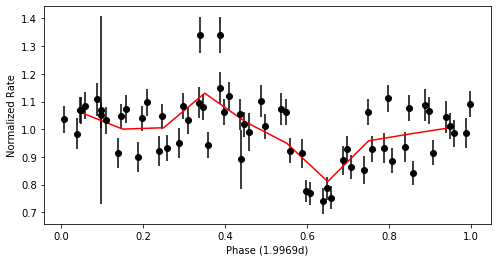

In [204]:
fr2,avg = nfold(fr,1.9969,pbins=10)

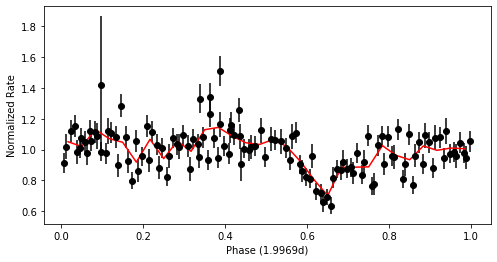

In [214]:
#another example: smaller initial binning, larger phase bins
fr3,avg = nfold(tabs,1.9969,dbin=0.05,pbins=30)
sf('fold0.5_30')

In [228]:
def ztest(evt,pds,dbin=0.1,pbins=16):
    '''Perform ztest for some set of periods, with given binnings.'''
    slist = []
    for p in pds:
        fr,avgs = nfold(evt,p,dbin=dbin,pbins=pbins,color='red',linestyle='solid')
        mean = np.mean(avgs)
        s = np.sum(((avgs-mean)**2)/np.sqrt(mean)**2)
        slist.append(s)
    plt.close()
    plt.plot(pds,slist,color='black')
    best = pds[np.where(slist==np.max(slist))[0][0]]
    print(best)
    plt.axvline(best,color='red')
    return slist

1.9949999999999894


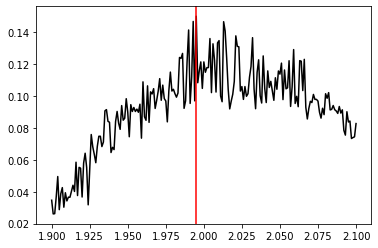

In [231]:
slist = ztest(fr,np.arange(1.9,2.1,.001))

2.008999999999988


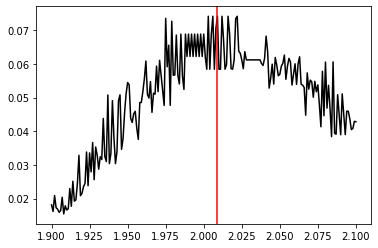

In [234]:
slist = ztest(fr,np.arange(1.9,2.1,.001),dbin=0.05,pbins=10)